# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


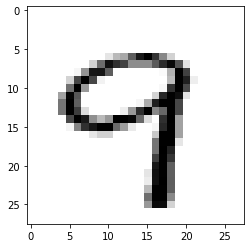

In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

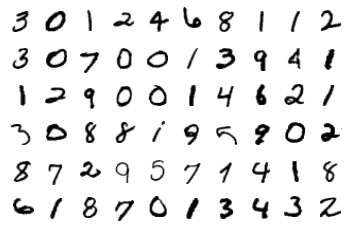

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [29]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [30]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10780925303697586 Batch_id=468 Accuracy=86.44: 100%|██████████| 469/469 [00:12<00:00, 38.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0849, Accuracy: 9764/10000 (97.64%)

EPOCH: 1


Loss=0.042189907282590866 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:12<00:00, 38.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.06880923360586166 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0442, Accuracy: 9869/10000 (98.69%)

EPOCH: 3


Loss=0.05661704018712044 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:12<00:00, 36.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.014654275961220264 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:12<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.02928864397108555 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:12<00:00, 38.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.04999209940433502 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 38.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.05359287187457085 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:12<00:00, 38.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.03813629969954491 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:11<00:00, 39.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.013511385768651962 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 39.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.015718229115009308 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:12<00:00, 38.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.004027442540973425 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:11<00:00, 39.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.0478043258190155 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:11<00:00, 39.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.0034480250906199217 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:11<00:00, 40.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.019189516082406044 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:11<00:00, 40.28it/s]



Test set: Average loss: 0.0239, Accuracy: 9922/10000 (99.22%)



Text(0.5, 1.0, 'Test Accuracy')

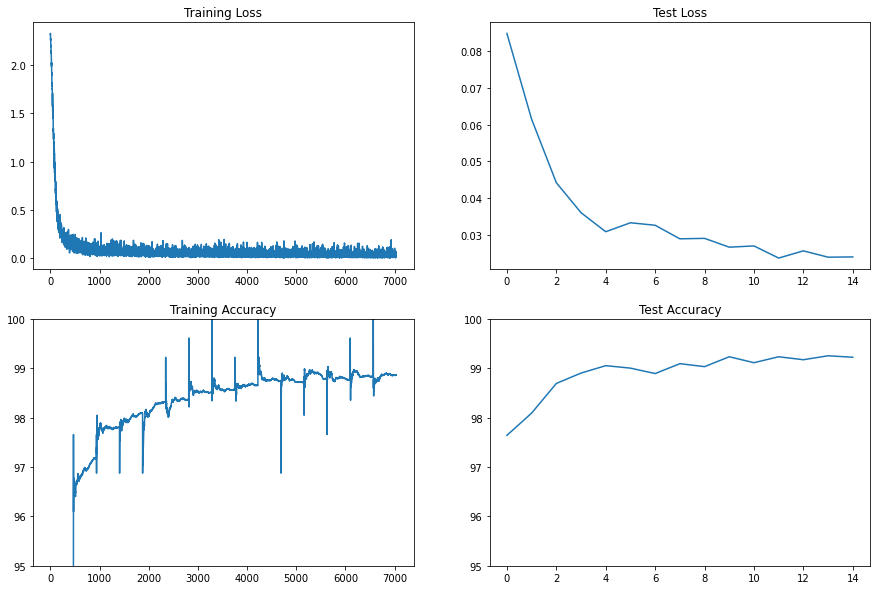

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=95,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=95,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")